# Data Visualization
By G Hosseinzadeh 2025 Apr 17

This notebook will show off some of the convenient features of using Astropy to read astronomical data files and then plotting the data with Matplotlib plus Astropy's visualization tools.

First of all, when making plots for a paper, I like to use serif fonts to match the text in the journal. You can set this globally for the notebook using the `plt.rcParams` dictionary.

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'             # axis labels and any other normal text
plt.rcParams['mathtext.fontset'] = 'dejavuserif'  # text processed through LaTeX (e.g., units)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

## Problem 1: Displaying a FITS Image

Astropy has a lot of tools to help read and display astronomical images. Read in one of the Astropy test images and display it as nicely as possible. Keep the following in mind:
1. I suggest reading in the file as an `astropy.nddata.CCDData` object, which automatically handles the data, header, coordinate system, units, etc.
2. The image has bright sources and faint nebulosity, so you probably want a nonlinear stretch. Use `astropy.visualization.imshow_norm` with the provided stretch and interval classes. You'll need to play around with this until it looks good.
3. The image is in Galactic coordinates, so label the $x$-axis "Galactic Longitude" and the $y$-axis "Galactic Latitude." Add a coordinate grid, and give the values in degrees and arcminutes.
4. The image is in physical units of W / (m$^2$ sr). Add a colorbar showing how the colors correspond to these units, and add a label to the colorbar axis.
5. (*challenge*) Add an overlay grid with equatorial coordinates (R.A. and dec.).

In [3]:
from astropy.utils.data import get_pkg_data_filename
from astropy.nddata import CCDData
from astropy import units as u
from astropy import visualization as viz

INFO: using the unit W / (sr m2) passed to the FITS reader instead of the unit W/m^2-sr in the FITS file. [astropy.nddata.ccddata]


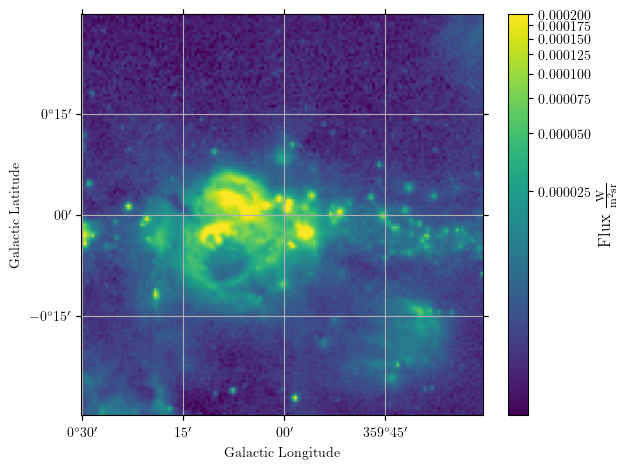

In [4]:
# get the name of the file from Astropy's data server
filename = get_pkg_data_filename('galactic_center/gc_msx_e.fits')

# read the file in as a CCDData object; the units are formatted incorrectly in the header
ccddata: CCDData = CCDData.read(filename, unit=u.W / ((u.m**2)*u.sr))

# create a new figure and axis with a WCS projection
fig = plt.figure()
ax = fig.add_subplot(projection = ccddata.wcs)

# display the image on that axis with a nice stretch
im = viz.imshow_norm(ccddata, ax, interval=viz.PercentileInterval(99), stretch=viz.LogStretch(100), cmap = 'viridis')

# format the axes
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")

# add a color bar
cbar = fig.colorbar(im[0], ax=ax)
cbar.set_label(r'\large Flux $\frac{\unit{W}}{\unit{m}^{2}\unit{sr}}$')

# add the overlay grid
ax.grid()
# remove padding around axes in figure
fig.tight_layout()
# save the results
fig.savefig('data-visualization.png')

Now create exactly the same figure, but zoom in only on the brightest part in the middle of the image. **Don't do this by setting the axis limits.** Instead, cut out that part of the `CCDData` object and plot only that. Notice how all the coordinates and brightness values are adjusted accordingly.

In [5]:
from astropy.visualization import wcsaxes as wcsa

INFO: using the unit W / (sr m2) passed to the FITS reader instead of the unit W/m^2-sr in the FITS file. [astropy.nddata.ccddata]


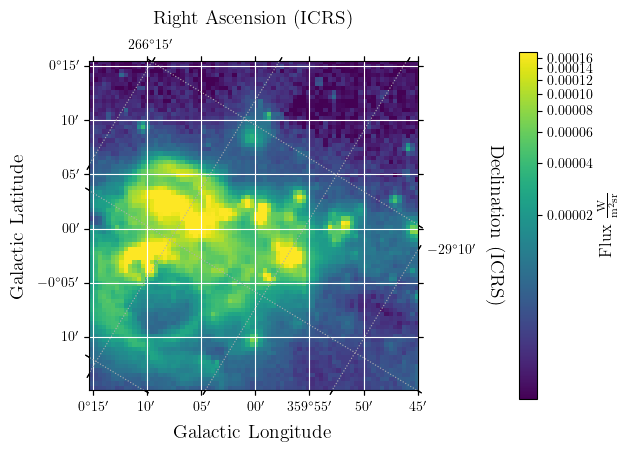

In [6]:
# get the name of the file from Astropy's data server
filename = get_pkg_data_filename('galactic_center/gc_msx_e.fits')

# read the file in as a CCDData object; the units are formatted incorrectly in the header
ccddata: CCDData = CCDData.read(filename, unit=u.W / ((u.m**2)*u.sr))
ccddata = ccddata[int(ccddata.shape[0]/4): int(1-ccddata.shape[0]/4), int(ccddata.shape[1]/4): int(1-ccddata.shape[1]/4)]

# create a new figure and axis with a WCS projection
fig = plt.figure()
ax: wcsa.WCSAxes = plt.subplot(projection=ccddata.wcs)
fig.add_axes(ax)

# display the image on that axis with a nice stretch
im = viz.imshow_norm(ccddata, ax, interval=viz.PercentileInterval(95), stretch=viz.LogStretch(100), cmap = 'viridis')

# format the axes   
ax.set_xlabel("Galactic Longitude", fontsize=14)
ax.set_ylabel("Galactic Latitude", fontsize=14)

# add a color bar
cbar = fig.colorbar(im[0], ax=ax, pad = 0.2)
cbar.set_label(r'\large Flux $\frac{\unit{W}}{\unit{m}^{2}\unit{sr}}$')

# add the overlay grid
ax.coords.grid(color='w')
wcs_grid: wcsa.CoordinatesMap = ax.get_coords_overlay('fk5')
wcs_grid.grid(linestyle='dotted')
wcs_grid[0].set_axislabel('Right Ascension (ICRS)', fontsize=14)
wcs_grid[1].set_axislabel('Declination (ICRS)', fontsize=14)

# remove padding around axes in figure
fig.tight_layout()

# save the results
fig.savefig('data-visualization.png')

## Challenge Problem: Reproduce this plot!
![Hosseinzadeh et al. 2022, Figure 6](https://content.cld.iop.org/journals/2041-8205/933/2/L45/revision1/apjlac7ceff6_hr.jpg)

If you'd like some context, the plot comes from Figure 6 of [this paper](https://iopscience.iop.org/article/10.3847/2041-8213/ac7cef#apjlac7ceff6). It's okay if you can't match everything perfectly, but get as close as you can.

The data for the 12 spectra are included in this repository in the `SN2021aefx_early_spectra` directory. Each file is a two-column text file with wavelength (in ångströms) and flux. In addition to converting the wavelength units, you'll have to correct for the redshift of the target, $z=0.005017$, to get the rest wavelength.

Hint: To convert between wavelength and expansion velocity, try the [Doppler formula](https://en.wikipedia.org/wiki/Doppler_effect). In this case, the emitting material is moving toward us.

In [7]:
from astropy.table import Table
from astropy import constants as const
from glob import glob
import numpy as np

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

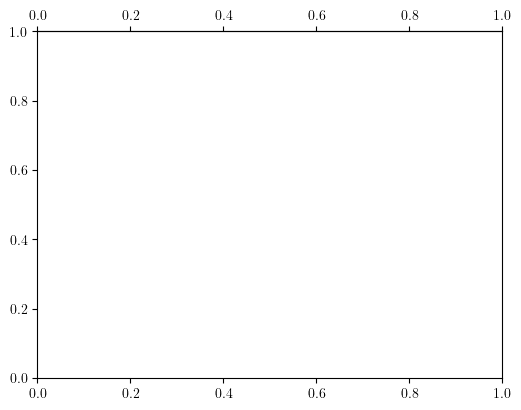

In [21]:
# create a figure with a single blank axes object
fig, ax = plt.subplots(figsize=(6., 4.5))

# create an upper x-axis that shares the same y-axis
ax.secondary_xaxis('top')

# find all the filenames in that directory and sort them alphabetically
filenames = sorted(glob('SN2021aefx_early_spectra/*'))

# plot the data in each spectrum file
for fn in filenames:
    data = Table.read(fn, names=['Rest Wavelength', 'Flux'], format='ascii')
    wavelength_mask = 5200. < data['Rest Wavelength'] < 6400.
    data = data[wavelength_mask]
    ax.plot(data['Rest Wavelength'], data['Flux'])
    break

# format lower x-axis and y-axis

# format upper x-axis

# add text annotations

# remove padding around axes in figure

# save the results
